# TASK

Consider the large scale Twitter friendship dataset available at Twitter Friends (kaggle.com) of full
Twitter user profile data (40K users), including friendship relationship. We want to explore this
friendship relation to construct a network graph where User IDs are nodes and a directed edge from
IDx to IDy if IDy is listed as a friend of IDx.

1. Use NetworkX to display the corresponding network, suggest an approach to visualize this
dense network using visualization tool of your choice (NetworkX is not ideal for dense
graphs). Save the adjacency matrix of this graph in a separate file.
2. Write a script that uses NetworkX functions to calculate diameter, average clustering
coefficient and average path length of the network.
3. Write a script that plots the degree centrality distribution and closeness centrality
distribution.
4. We want to test the extent to which the centrality distributions in 3) fit a power law
distribution. You may inspire from the implementation in powerlaw · PyPI of the power-law
distribution, or can use alternative one of your choice. It is important to quantify the
goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that
power-law is a plausible fit to the (distribution) data.
5. Write a script that calculates the number of triangles in the network.
6. Write a script that identifies the largest strongly connected component, second largest, third
largest. Display each component (If there is more than one component for a given case,
then draw one at random).
7. Write a script that calculates the shortest distance between any pair of the strongly
connected components in 5). Present the result in a table. Comment on the separability
between the above components.
8. We want to identify relevant communities from the subnetwork graph corresponding to the
largest, second largest and third largest component. For this purpose, use Label propagation
algorithm implementation in NetworkX to identify the main communities. Write a script
that uses different color for each community and visualize the above graph with the detected
communities. Use the appropriate function in NetworkX to compute the separation among
the various communities and any other related quality measures. Comment on the quality of
the partition.
9. We want to evaluate the evolution of the triangles (transitivity relation in the network). For
this purpose, we consider time increment as an accumulation of one thousand successive
rows in the original dataset. Suggest a script that calculates the evolution of the proportion
of triangles (number of triangles over the total number of nodes up to time t, basically t=1,
2,…,40), and draws the corresponding graph.
10. From 9), write a script that identifies instances of triplet nodes A, B, C such at time t A is
connected to B and B is connected to C but A is not connected to C, while in time t+1, A
becomes connected to C. Check for theses instances whether the link prediction using
common neighbor (probability A being connected to C increases with the number of
common neighbours between A and B). Write the result in a table.
11. Suggest appropriate literature to comment on the various findings and explore the limitation
of the reasoning pipeline.

The data contains the following columns:
- avatar: URL to the profile picture
- followerCount: the number of followers of this user
- friendsCount: the number of people following this user
- friendName: stores the @name (without the '@') of the user (beware this name can be changed by the user)
- id: user ID, this number can not change (you can retrieve screen name with this service: https://tweeterid.com/)
- friends: the list of IDs the user follows (data stored is IDs of users followed by this user)
- lang: the language declared by the user (in this dataset there is only "en" (english))
- lastSeen: the time stamp of the date when this user have post his last tweet
- tags: the hashtags (with or without #) used by the user. It's the "trending topic" the user tweeted about
- tweetID: ID of the last tweet posted by this user

In [1]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import scipy
import powerlaw
import pandas as pd
import random as rd
import json

import matplotlib.cm as cm
import networkx.algorithms.community as nx_comm

Download the dataset from [here](https://www.kaggle.com/datasets/hwassner/TwitterFriends/download?datasetVersionNumber=4)

And unzip the file to get the `data.csv` file.

In [3]:
# open the csv file
with open('data.csv', 'r') as f:
    data = f.readlines()

# remove the first line
data = data[1:]



# Read the data into a pandas dataframe and remove the quotes
df = pd.read_csv('data.csv', sep=',(?=\S)', engine='python')

def delete_quotes(x):
    return x[1:-1]

for column in ["id", "screenName", "avatar", "lang", "tweetId"]:
    df[column] = df[column].apply(delete_quotes)

for column in ["tags", "friends"]:
    df[column] = df[column].apply(lambda x: json.loads(x))

df.head()



<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\S'
C:\Users\joona\AppData\Local\Temp\ipykernel_23692\1091888442.py:11: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv('data.csv', sep=',(?=\S)', engine='python')


,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,1969527638,LlngoMakeEmCum_,[#nationaldogday],http://pbs.twimg.com/profile_images/5342862178...,319,112,en,1472271687519,769310701580083200,"[1969574754, 1969295556, 1969284056, 196961221..."
1,51878493,_notmichelle,[#nationaldogday],http://pbs.twimg.com/profile_images/7619776021...,275,115,en,1472270622663,769309490038439936,"[60789485, 2420931980, 2899776756, 127410795, ..."
2,1393409100,jesseayye,[#narcos],http://pbs.twimg.com/profile_images/7132829382...,120,107,en,1472804144409,771622623583186944,"[86868062, 19697415, 2998836604, 456295047, 74..."
3,232891415,MrBrianLloyd,[#gloryoutnow],http://pbs.twimg.com/profile_images/1334406683...,492,325,en,1472269186776,769308131696467969,"[361335082, 1405248468, 24626354, 725675895965..."
4,710130422907207680,sarahdorat_16,[#nationaldogday],http://pbs.twimg.com/profile_images/7671805202...,128,218,en,1472271397356,769309769144283137,"[1571896093, 768938323612008448, 2548665930, 3..."


In [4]:
'''
1. Use NetworkX to display the corresponding network, suggest an approach to visualize this
dense network using visualization tool of your choice (NetworkX is not ideal for dense
graphs). Save the adjacency matrix of this graph in a separate file.

TODO: Alternative visualization
'''

def create_directed_graph(df):
    """
    Use directed graph to represent the network

    We want to explore this friendship relation to construct a network graph where User IDs are nodes
    and a directed edge from IDx to IDy if IDy is listed as a friend of IDx.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes from 'id' column
    G.add_nodes_from(df['id'])

    # Add edges from 'id' to 'friends' if 'friend' is also a node in the graph
    for _, row in df.iterrows():
        id = row['id']
        friends = row['friends']
        for friend in friends:
            if friend in G:
                G.add_edge(id, friend)

    print(f'Number of nodes: {G.number_of_nodes()} Number of edges: {G.number_of_edges()}')
    return G

def save_adjacency_matrix(G, filename):
    adjacency_matrix = nx.adjacency_matrix(G)
    with open(filename, 'wb') as f:
        np.save(f, adjacency_matrix)


G = create_directed_graph(df)
save_adjacency_matrix(G, 'adjacency_matrix.npy')


Number of nodes: 40000 Number of edges: 184548


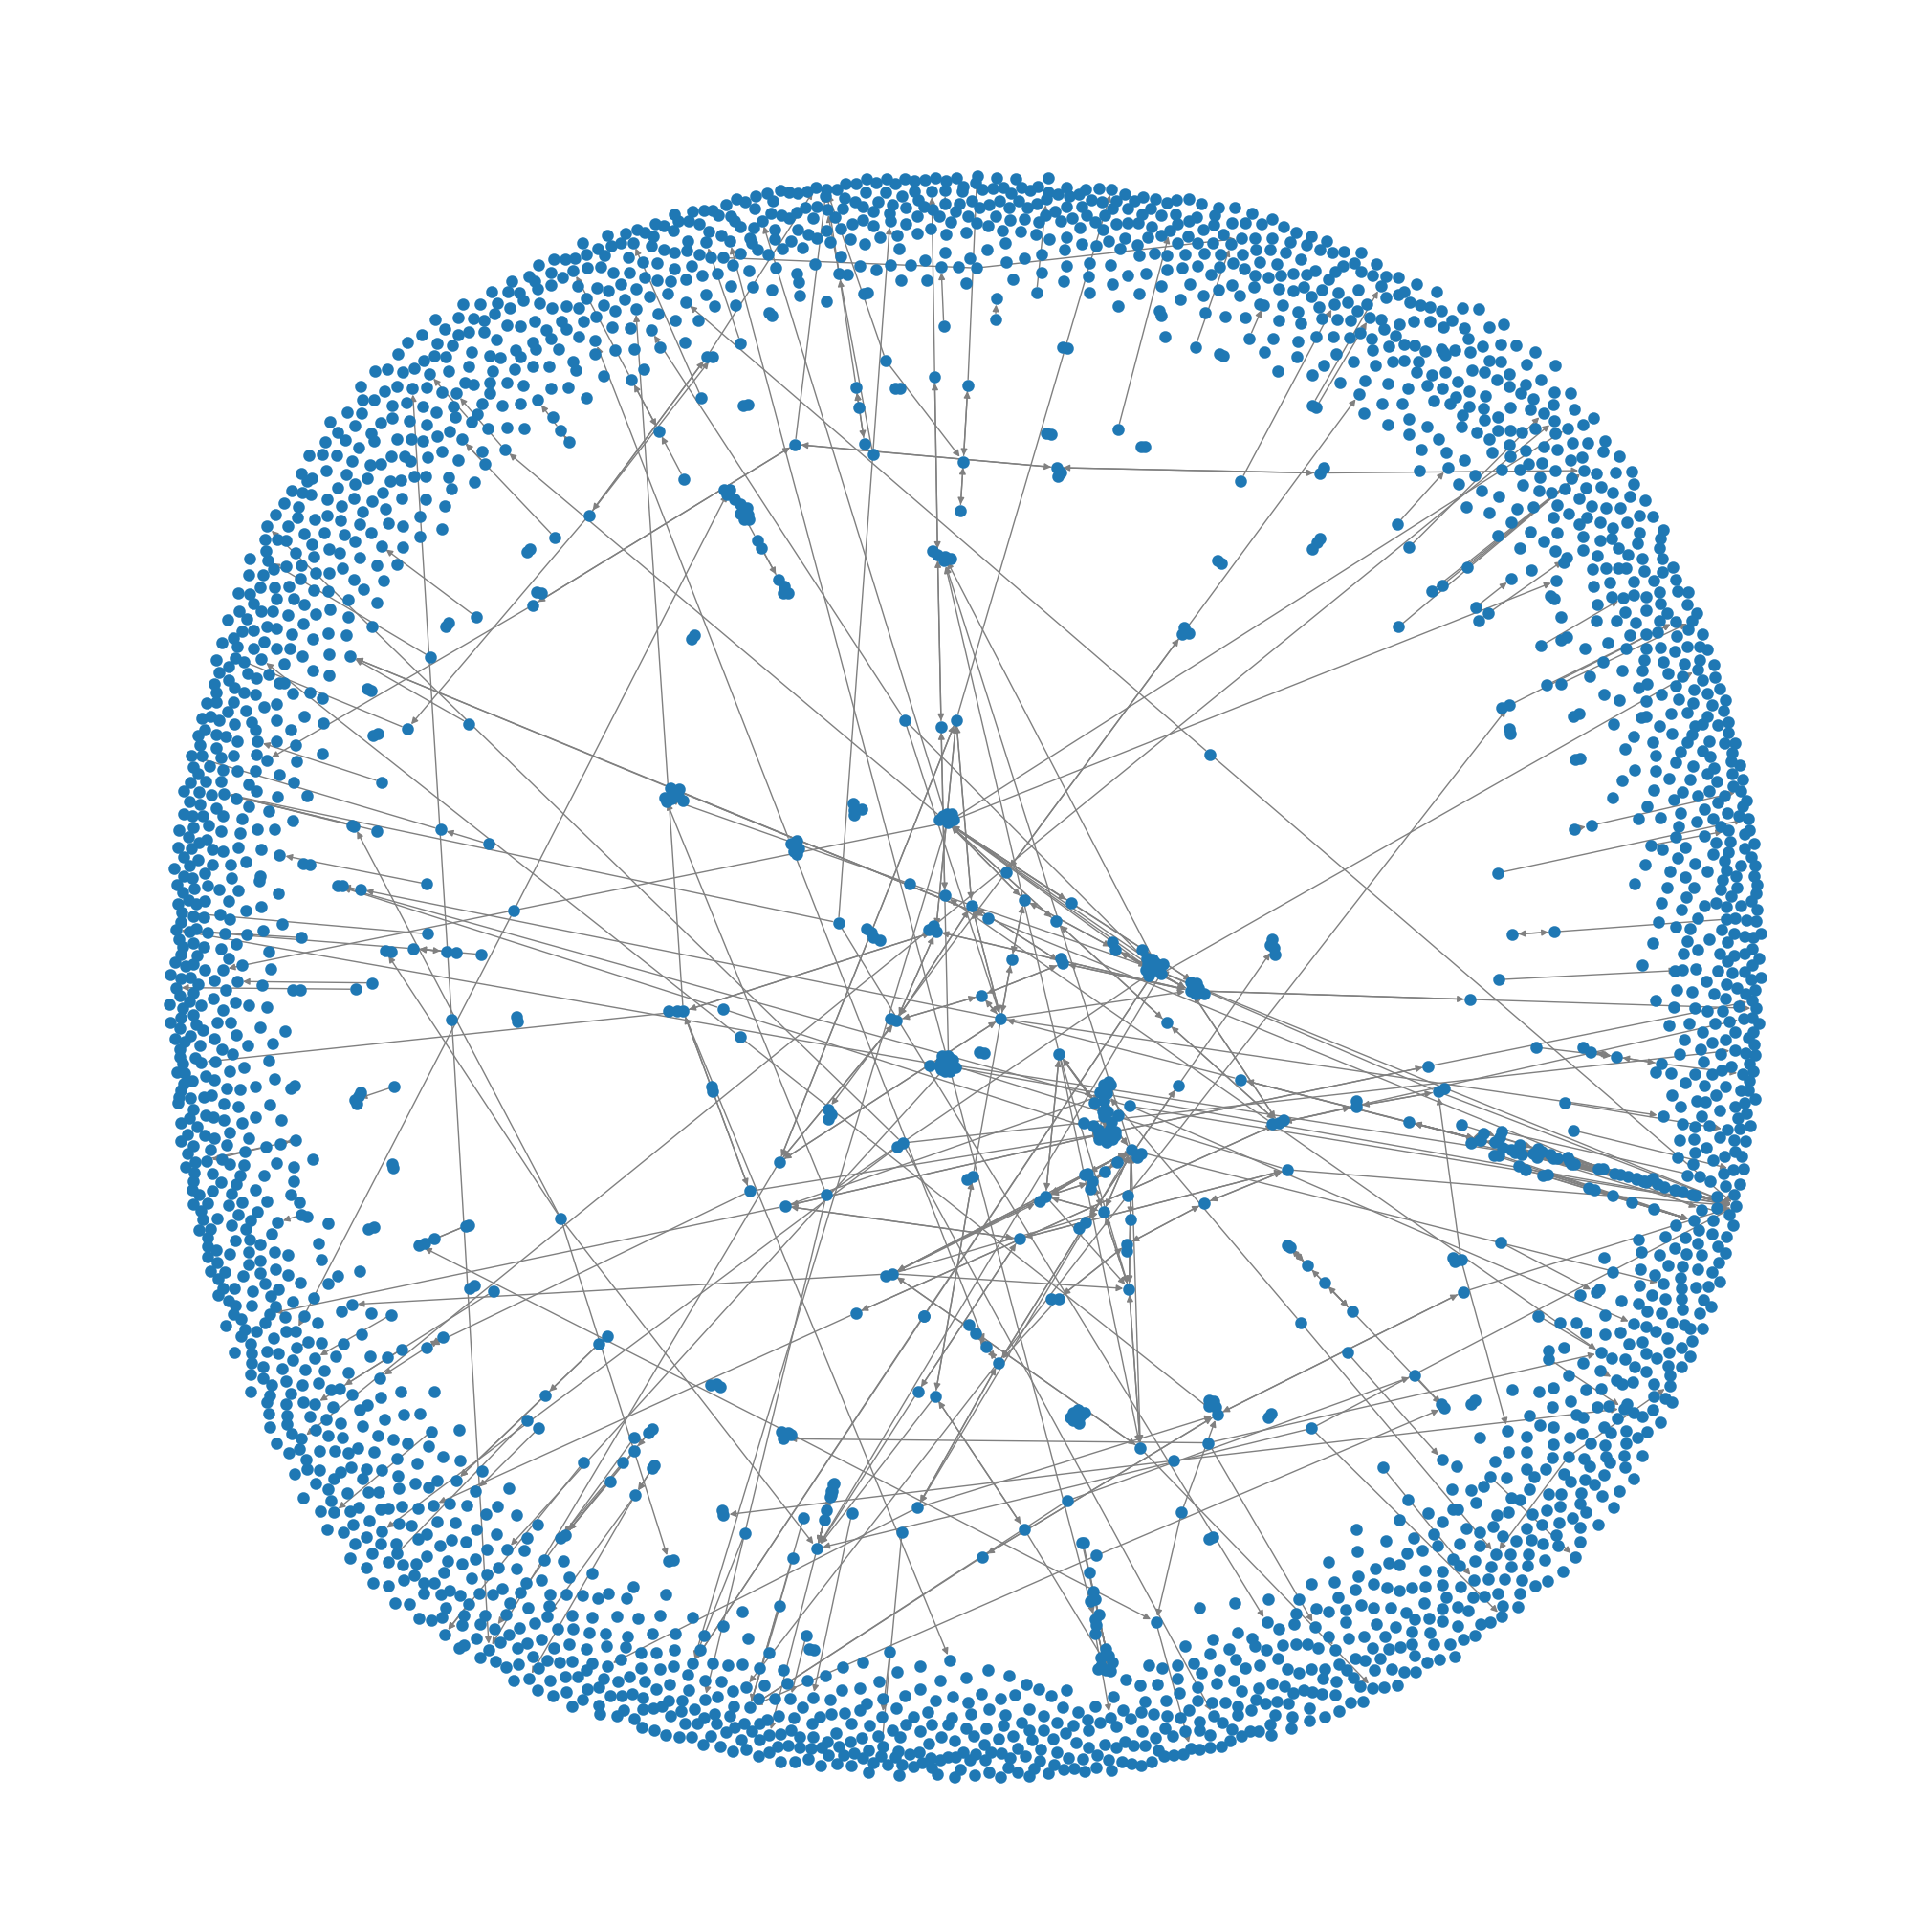

In [5]:

# create a visualization using Cytoscape (GraphML)
nx.write_graphml(G, "twitter_dataset.graphml")

# Visualize the graph using NetworkX (not ideal for dense graphs)
# draw only the first 3000 nodes
G_copy = G.subgraph(list(G.nodes())[:3000])
pos = nx.spring_layout(G_copy)
plt.figure(figsize=(20, 20))
nx.draw(G_copy, pos, with_labels=True, labels=nx.get_node_attributes(G_copy, 'screenName'), node_size=80, font_size=6, linewidths=0.1, edge_color='gray')
plt.show()



In [6]:
'''
2. Write a script that uses NetworkX functions to calculate diameter, average clustering
coefficient and average path length of the network.
'''

def calculate_metrics(G):
    # Calculate shortest path lengths
    print("Calculating shortest path lengths")
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    print("sorted shortest path lengths")

    # # Calculate diameter
    diameter = max([max(lengths.values()) for lengths in shortest_path_lengths.values()])
    print(f"Diameter: {diameter}")


    # Calculate average path length for all the components
    avg_path_lengths = []
    for lengths in shortest_path_lengths.values():
        avg_path_lengths.append(np.mean(list(lengths.values())))
    avg_path_length = np.mean(avg_path_lengths)
    print(f"Average Path Length: {avg_path_length}")

    # Calculate average clustering coefficient
    avg_clustering_coefficient = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering_coefficient}")

    # Calculate degree distribution
    degrees = dict(G.degree())
    degree_values = list(degrees.values())
    degree_values = np.array(degree_values)
    degree_values = degree_values[degree_values > 0]
    degree_values = np.log(degree_values)
    fit = powerlaw.Fit(degree_values)
    alpha = fit.alpha
    print(f"ALPHA: {alpha}")
    print(f"XMIN: {fit.power_law.xmin}")
    print(f"SIGMA: {fit.power_law.sigma}")
    print(f"XMAX: {fit.power_law.xmax}")

calculate_metrics(G)

Calculating shortest path lengths
sorted shortest path lengths
Diameter: 25
Average Path Length: 4.668414626749954
Average Clustering Coefficient: 0.08924715939198709
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


ALPHA: 9.39340835019796
XMIN: 4.189654742026425
SIGMA: 0.29938296114064256
XMAX: None


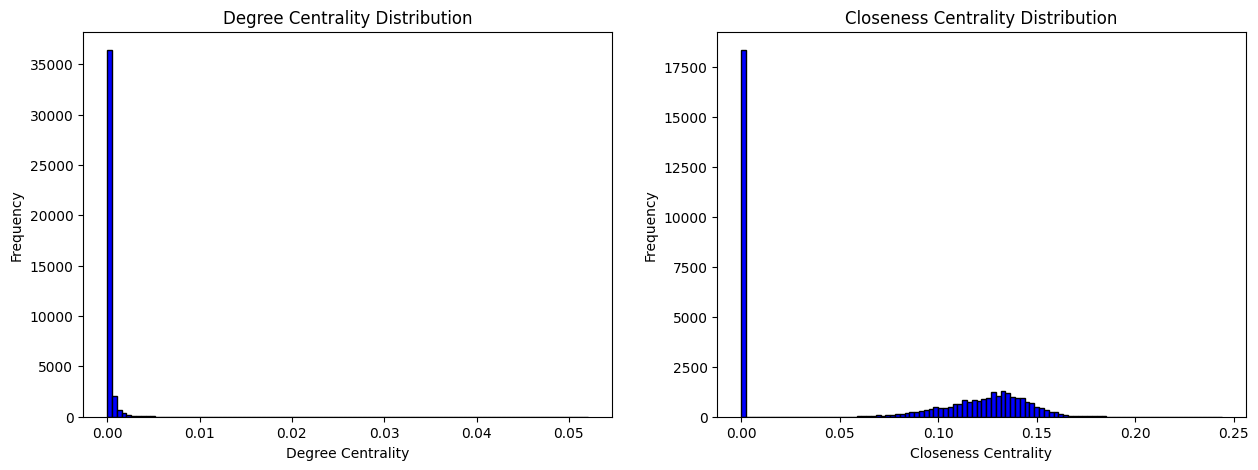

In [7]:
'''
3. Write a script that plots the degree centrality distribution and closeness centrality
distribution.
'''

def plot_degree_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)


    # Plot degree centrality distribution and closeness centrality distribution
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(degree_centrality.values(), bins=100, color='blue', edgecolor='black')
    ax[0].set_title("Degree Centrality Distribution")
    ax[0].set_xlabel("Degree Centrality")
    ax[0].set_ylabel("Frequency")

    ax[1].hist(closeness_centrality.values(), bins=100, color='blue', edgecolor='black')
    ax[1].set_title("Closeness Centrality Distribution")
    ax[1].set_xlabel("Closeness Centrality")
    ax[1].set_ylabel("Frequency")

    plt.show()


plot_degree_centrality(G)


In [9]:
'''
4. We want to test the extent to which the centrality distributions in 3) fit a power law
distribution. You may inspire from the implementation in powerlaw PyPI of the power-law
distribution, or can use alternative one of your choice. It is important to quantify the
goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that
power-law is a plausible fit to the (distribution) data.
'''

def fit_power_law(G):
    # Calculate degree centrality and closeness centrality
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Fit the degree centrality distribution to a power-law distribution and compare with lognormal
    cent_values = list(degree_centrality.values())
    # print(cent_values)
    fit_degree = powerlaw.Fit(cent_values)
    R, p = fit_degree.distribution_compare('power_law', 'lognormal')
    print(f"Degree Centrality: p-value = {p}")
    if p > 0.1:
        print("Power-law is a plausible fit to degree centrality data")
    else:
        print("Power-law is not a plausible fit to degree centrality data")

    # Fit the closeness centrality distribution to a power-law distribution and compare with lognormal
    closeness_values = list(closeness_centrality.values())
    # print(closeness_values)
    fit_closeness = powerlaw.Fit(closeness_values)
    R, p = fit_closeness.distribution_compare('power_law', 'lognormal')
    print(f"Closeness Centrality: p-value = {p}")
    if p > 0.1:
        print("Power-law is a plausible fit to closeness centrality data")
    else:
        print("Power-law is not a plausible fit to closeness centrality data")


fit_power_law(G)


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Degree Centrality: p-value = 0.7241741494555731
Power-law is a plausible fit to degree centrality data
Calculating best minimal value for power law fit
Closeness Centrality: p-value = 0.8096715034525699
Power-law is a plausible fit to closeness centrality data


In [10]:
'''
5. Write a script that calculates the number of triangles in the network.
'''

def count_triangles(G):
    triangles = nx.triangles(G)
    all_triangles = sum(triangles.values())
    # Each triangle is counted for all its three nodes
    # Divide by 3 to get the number of triangles in the graph
    num_triangles = all_triangles // 3
    if num_triangles == 0:
        print("No triangles found in the graph")
    else:
        print(f"Number of triangles: {num_triangles}")

undirected_G = G.to_undirected()
count_triangles(undirected_G)


Number of triangles: 139956


In [11]:
'''
6. Write a script that identifies the largest strongly connected component, second largest, third
'''

def find_strongly_connected_components(G):

    connected_components = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    strongly_connected = connected_components[:3]
    for i, component in enumerate(strongly_connected):
        subgraph = G.subgraph(component)
        print(f"Strongly connected component {i+1} has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
        if i == 2:
            break
    return connected_components

scc = find_strongly_connected_components(G)

Strongly connected component 1 has 20041 nodes and 149588 edges
Strongly connected component 2 has 42 nodes and 1495 edges
Strongly connected component 3 has 21 nodes and 51 edges


In [12]:
'''
7. Write a script that calculates the shortest distance between any pair of the strongly
connected components in 5). Present the result in a table. Comment on the separability
between the above components.
'''

def shortest_distance_between_components(G, components):
    shortest_distances = []
    for i in range(len(components)):
        for j in range(i+1, len(components)):
            component_i = list(components[i])
            component_j = list(components[j])
            shortest_distance = np.inf
            for node_i in component_i:
                for node_j in component_j:
                    if nx.has_path(G, node_i, node_j):
                        distance = nx.shortest_path_length(G, node_i, node_j)
                        if distance < shortest_distance:
                            shortest_distance = distance
            shortest_distances.append((i+1, j+1, shortest_distance))
    return shortest_distances


def present_results_in_table(shortest_distances):
    df = pd.DataFrame(shortest_distances, columns=['Component 1', 'Component 2', 'Shortest Distance'])
    return df

shortest_distances = shortest_distance_between_components(G, scc)
df = present_results_in_table(shortest_distances)
print(df)


KeyboardInterrupt: 

If the shortest distance between any pair of components is large, it indicates that these components are well separated.

If the shortest distance is small, it suggests that these components are closely connected.

In [ ]:
'''
8. We want to identify relevant communities from the subnetwork graph corresponding to the
largest, second largest and third largest component. For this purpose, use Label propagation
algorithm implementation in NetworkX to identify the main communities. Write a script
that uses different color for each community and visualize the above graph with the detected
communities. Use the appropriate function in NetworkX to compute the separation among
the various communities and any other related quality measures. Comment on the quality of
the partition.

'''

def plot_communities(G, node_groups):
    colors = [
        f"#{''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])}"
        for _ in range(len(node_groups))
    ]
    color_map = []
    for node in G:
        found = False
        for i, node_group in enumerate(node_groups):
            if node in node_group:
                color_map.append(colors[i % len(colors)])
                found = True
        if not found:
            color_map.append("grey")
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()


def detect_communities(G):
    connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
    for i, component in enumerate(connected_components):
        subgraph = G.subgraph(component)
        communities_generator = nx_comm.asyn_lpa_communities(subgraph)
        communities = list(communities_generator)  # Convert generator to list
        community_map = {}
        for j, community in enumerate(communities):
            for node in community:
                community_map[node] = j


        plot_communities(subgraph, communities)

        # Compute the modularity of the partition
        modularity = nx_comm.modularity(subgraph, communities)
        print(f"Modularity of the partition: {modularity}")

        # Compute the partition_quality
        coverage, performance = nx_comm.partition_quality(subgraph, communities)
        print(f"Coverage: {coverage}", f"Performance: {performance}")


        if i == 2:
            break

detect_communities(undirected_G)

def print_performance_metrics(G, communities):

    print("Modularity:", nx_comm.modularity(G, communities))
    coverage, performance = nx_comm.partition_quality(G, communities)
    print("Coverage:", coverage)
    print("Performance:", performance)
    print("")

def label_propagation_identification(G, components):
    largest_components = components[:3]
    for component in largest_components:
        subgraph = G.subgraph(component)
        communities = list(nx_comm.label_propagation_communities(subgraph))
        print_performance_metrics(subgraph, communities)
        plot_communities(subgraph, communities)


#label_propagation_identification(undirected_G, scc)

In [ ]:
'''
9. We want to evaluate the evolution of the triangles (transitivity relation in the network). For
this purpose, we consider time increment as an accumulation of one thousand successive
rows in the original dataset. Suggest a script that calculates the evolution of the proportion
of triangles (number of triangles over the total number of nodes up to time t, basically t=1,
2,…,40), and draws the corresponding graph.

'''

def calculate_triangle_evolution(G):
    triangles = nx.triangles(G)
    num_triangles = sum(triangles.values())
    num_nodes = G.number_of_nodes()
    proportions = []
    for i in range(1, 41):
        subgraph = G.subgraph(list(G.nodes())[:i*1000])
        triangles = nx.triangles(subgraph)
        num_triangles = sum(triangles.values())
        proportion = num_triangles / num_nodes
        proportions.append(proportion)

    plt.plot(range(1, 41), proportions)
    plt.xlabel("Time")
    plt.ylabel("Proportion of triangles")
    plt.title("Evolution of the proportion of triangles")
    plt.show()


calculate_triangle_evolution(G)

In [ ]:
'''
10. From 9), write a script that identifies instances of triplet nodes A, B, C such at time t A is
connected to B and B is connected to C but A is not connected to C, while in time t+1, A
becomes connected to C. Check for theses instances whether the link prediction using
common neighbor (probability A being connected to C increases with the number of
common neighbours between A and B). Write the result in a table.

'''

def link_prediction(G):
    # Identify instances of triplet nodes A, B, C
    instances = []
    for i in range(1, 41):
        subgraph = G.subgraph(list(G.nodes())[:i*1000])
        for node in subgraph.nodes():
            neighbors = list(subgraph.neighbors(node))
            for neighbor in neighbors:
                other_nodes = [n for n in subgraph.nodes() if n != node and n != neighbor]
                for other_node in other_nodes:
                    if other_node not in neighbors and other_node in list(subgraph.neighbors(neighbor)):
                        instances.append((node, neighbor, other_node))

    # Check if A becomes connected to C at time t+1
    rows = []
    for instance in instances:
        A, B, C = instance
        if G.has_edge(A, C):
            continue
        if G.has_edge(A, B) and G.has_edge(B, C):
            common_neighbors = list(nx.common_neighbors(G, A, C))
            row = pd.DataFrame({'A': [A], 'B': [B], 'C': [C], 'Common Neighbors': [len(common_neighbors)]})
            rows.append(row)
    if rows:
        table = pd.concat(rows, ignore_index=True)
        print(table)
    else:
        print("No instances found")

link_prediction(G)

In [ ]:
'''
11. Suggest appropriate literature to comment on the various findings and explore the limitation
of the reasoning pipeline.
'''